In [1]:
import os

import numpy as np
import pandas as pd

import scanpy as sc

In [2]:
sc.set_figure_params(dpi=80, dpi_save=300)

In [4]:
import time
import logging
logging.basicConfig(filename='./logging.txt', level=logging.INFO)

In [6]:
dge_1 = pd.read_csv("../orig_data/Lung_1_500more_dge.txt.gz", sep=' ').fillna(0)
dge_2 = pd.read_csv("../orig_data/Lung_2_500more_dge.txt.gz", sep=' ').fillna(0)
dge_3 = pd.read_csv("../orig_data/Lung_3_500more_dge.txt.gz", sep=' ').fillna(0)
#dge_4 = pd.read_csv("../../orig_data/Lung_P7_8_dge.txt.gz", sep=' ').fillna(0)
#dge_5 = pd.read_csv("../../orig_data/Lung_P7_9_dge.txt.gz", sep=' ').fillna(0)
merged_dge = pd.concat([dge_1, dge_2, dge_3], axis=1, join='inner')
#merged_dge = pd.concat([dge_4, dge_5], axis=1, join='inner')

In [8]:
print(merged_dge.shape)
print(merged_dge.index[1:5])
print(merged_dge.columns[1:5])

(17097, 9116)
Index(['0610007P14Rik', '0610009B22Rik', '0610009L18Rik', '0610009O20Rik'], dtype='object')
Index(['MCA_AdultLung_1.AACGCCGTCGGTCCTTTC',
       'MCA_AdultLung_1.CCGCTAAACGCCTCGGGT',
       'MCA_AdultLung_1.AGTCGTCCATCTGTATAC',
       'MCA_AdultLung_1.GCCTAGTGTCACTAGTCG'],
      dtype='object')


In [9]:
dge = sc.AnnData(merged_dge.T)

In [10]:
#check
print(dge.shape)
print(dge.obs_names[1:5])
print(dge.var_names[1:5])

(9116, 17097)
Index(['MCA_AdultLung_1.AACGCCGTCGGTCCTTTC',
       'MCA_AdultLung_1.CCGCTAAACGCCTCGGGT',
       'MCA_AdultLung_1.AGTCGTCCATCTGTATAC',
       'MCA_AdultLung_1.GCCTAGTGTCACTAGTCG'],
      dtype='object')
Index(['0610007P14Rik', '0610009B22Rik', '0610009L18Rik', '0610009O20Rik'], dtype='object')


In [11]:
np.where(np.isnan(dge.X))

(array([], dtype=int64), array([], dtype=int64))

In [12]:
anno_df = pd.DataFrame(dge.obs_names, columns=['CellID'])
anno_df['MCA_CellID'] = anno_df['CellID'].apply(lambda x: x.replace('MCA_Adult', ''))
anno_df['Batch'] = anno_df['CellID'].apply(lambda x: x.split('.')[0])

In [14]:
MCA_anno_df = pd.read_csv("../orig_data/cell-ann.csv", header=0, index_col=0, sep=',').drop(['Batch'], axis=1)

In [16]:
merged_anno_df = anno_df.join(MCA_anno_df, on='MCA_CellID', how='left')[['CellID', 'Batch', 'Cell.Anno' ]]

In [37]:
celltype_dict = {
    'AT1 cell':'AT1 cell',
    'AT1 Cell':'AT1 cell',
    'AT2 cell':'AT2 cell',
    'AT2 Cell':'AT2 cell',
    'Alveolar bipotent progenitor':'Progenitor cell',
    'Alveolar macrophage':'Macrophage',
    'B cell':'B cell',
    'B Cell':'B cell',
    'Basophil':'Basophil',
    'Ciliated cell':'Ciliated cell',
    'Conventional dendritic cell':'Dendritic cell',
    'Clara cell':'Clara cell',
    'Clara Cell':'Clara cell',
    'Dendritic cell':'Dendritic cell',
    'Dividing T cells':'T cell',
    'Dividing cells':'Dividing cell',
    'Dividing Dendritic cells':'Dendritic cell',
    'Dividing dendritic cells':'Dendritic cell',
    'Endothelial cell':'Endothelial cell',
    'Endothelial cells':'Endothelial cell',
    'Eosinophil granulocyte':'Eosinophil',
    'Interstitial macrophage':'Macrophage',
    'Monocyte progenitor cell':'Monocyte',
    'NK Cell':'NK cell',
    'Neutrophil granulocyte':'Neutrophil',
    'Nuocyte':'Nuocyte',
    'Plasmacytoid dendritic cell':'Dendritic cell',
    'Stromal cell':'Stromal cell',
    'T cell':'T cell',
    'T Cell':'T cell',
    'Ig−producing B cell':'B cell',
    'nan':'other',
}
def proc_cellAnno(x):
    x = str(x).replace('(Lung)', '').split('_')[0]
    if x in celltype_dict.keys():
        return celltype_dict[x]
    else:
        return x+'(Lung)'
merged_anno_df['CellType'] = merged_anno_df['Cell.Anno'].apply(proc_cellAnno)

In [38]:
#check
merged_anno_df.iloc[1000:1005, :]

,CellID,Batch,Cell.Anno,CellType
1000,MCA_AdultLung_1.GGCTGCCAACAATAGTCG,MCA_AdultLung_1,AT2 Cell(Lung),AT2 cell
1001,MCA_AdultLung_1.CTCCATCCATCTCCGCTA,MCA_AdultLung_1,Conventional dendritic cell_Mgl2 high(Lung),Dendritic cell
1002,MCA_AdultLung_1.TGCGGAGTCCCGATGGCG,MCA_AdultLung_1,AT1 Cell(Lung),AT1 cell
1003,MCA_AdultLung_1.CTCGCATATTGTAACGCC,MCA_AdultLung_1,Alveolar macrophage_Pclaf high(Lung),Macrophage
1004,MCA_AdultLung_1.CCAGACACGTTGATCAAC,MCA_AdultLung_1,Plasmacytoid dendritic cell(Lung),Dendritic cell


In [39]:
print(merged_anno_df['CellType'].unique())
print(merged_anno_df['CellType'].describe())

['Ciliated cell' 'Clara cell' 'AT2 cell' 'Macrophage' 'B cell' 'Monocyte'
 'other' 'AT1 cell' 'Stromal cell' 'Endothelial cell' 'NK cell'
 'Dendritic cell' 'T cell' 'Dividing cell' 'Nuocyte' 'Eosinophil'
 'Neutrophil' 'Basophil' 'Progenitor cell']
count      9116
unique       19
top       other
freq       2176
Name: CellType, dtype: object


In [40]:
for i in merged_anno_df.columns.values:
    dge.obs[i] = merged_anno_df[i].values

In [41]:
#check
print(dge.obs['CellID'][1:5])
print(dge.obs['Batch'].unique())
print(dge.obs['Batch'].describe())
print(dge)

MCA_AdultLung_1.AACGCCGTCGGTCCTTTC    MCA_AdultLung_1.AACGCCGTCGGTCCTTTC
MCA_AdultLung_1.CCGCTAAACGCCTCGGGT    MCA_AdultLung_1.CCGCTAAACGCCTCGGGT
MCA_AdultLung_1.AGTCGTCCATCTGTATAC    MCA_AdultLung_1.AGTCGTCCATCTGTATAC
MCA_AdultLung_1.GCCTAGTGTCACTAGTCG    MCA_AdultLung_1.GCCTAGTGTCACTAGTCG
Name: CellID, dtype: object
['MCA_AdultLung_1' 'MCA_AdultLung_2' 'MCA_AdultLung_3']
count                9116
unique                  3
top       MCA_AdultLung_3
freq                 4485
Name: Batch, dtype: object
AnnData object with n_obs × n_vars = 9116 × 17097 
    obs: 'CellID', 'Batch', 'Cell.Anno', 'CellType'


In [42]:
adata = dge.copy()

In [43]:
adata

AnnData object with n_obs × n_vars = 9116 × 17097 
    obs: 'CellID', 'Batch', 'Cell.Anno', 'CellType'

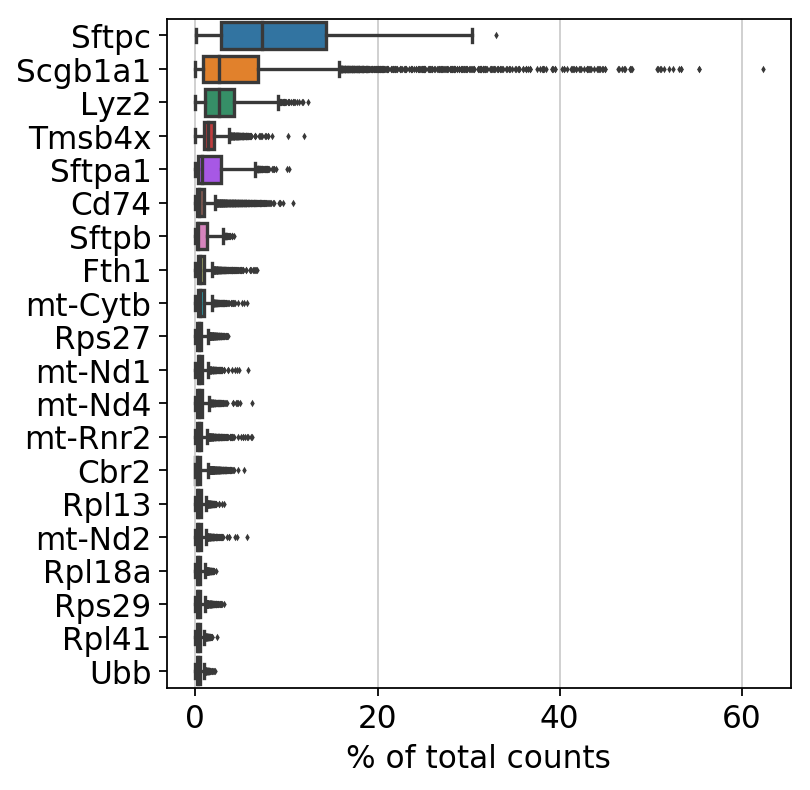

In [44]:
sc.pl.highest_expr_genes(adata, n_top=20)

In [45]:
# filter
sc.pp.filter_cells(adata, min_genes=20)
sc.pp.filter_genes(adata, min_cells=3)

In [46]:
adata

AnnData object with n_obs × n_vars = 9116 × 16755 
    obs: 'CellID', 'Batch', 'Cell.Anno', 'CellType', 'n_genes'
    var: 'n_cells'

In [47]:
mito_genes = [name for name in adata.var_names if name.startswith('mt-')]
adata.obs['percent_mito'] = np.sum(adata[:, mito_genes].X, axis=1) / np.sum(adata.X, axis=1)
adata.obs['n_counts'] = adata.X.sum(axis=1)

... storing 'Batch' as categorical
... storing 'Cell.Anno' as categorical
... storing 'CellType' as categorical


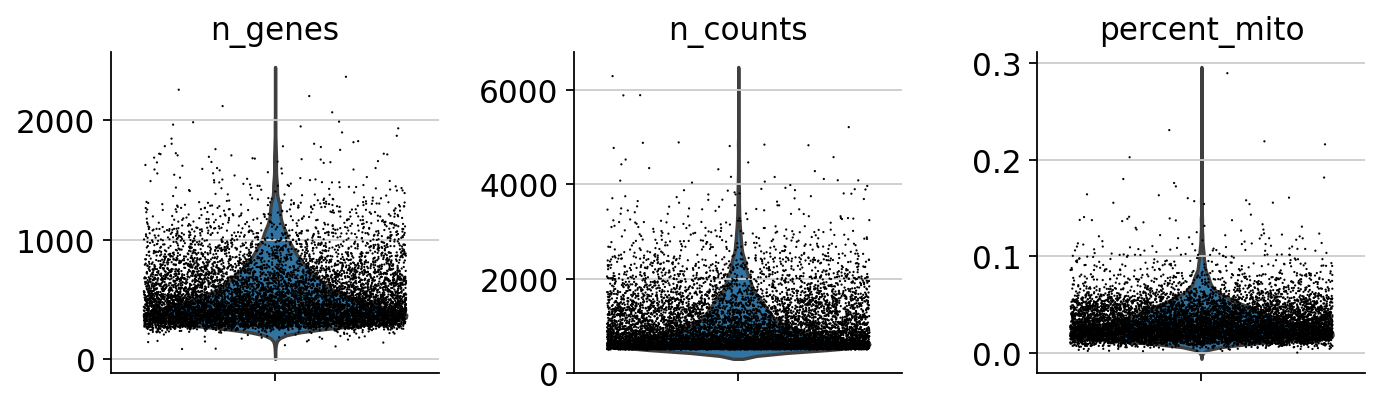

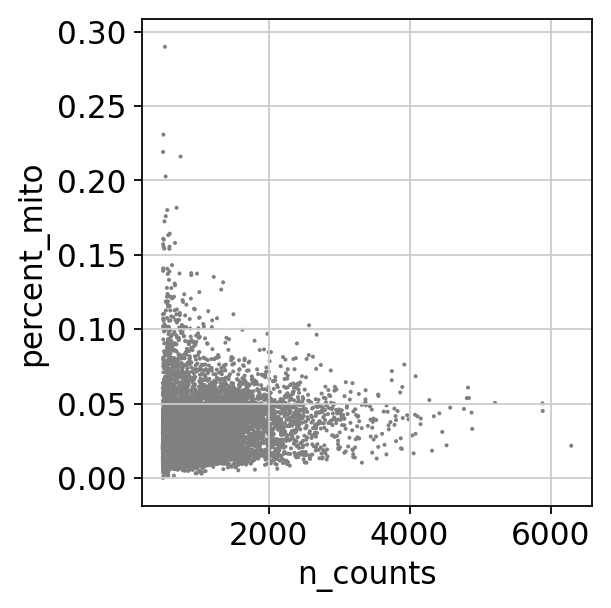

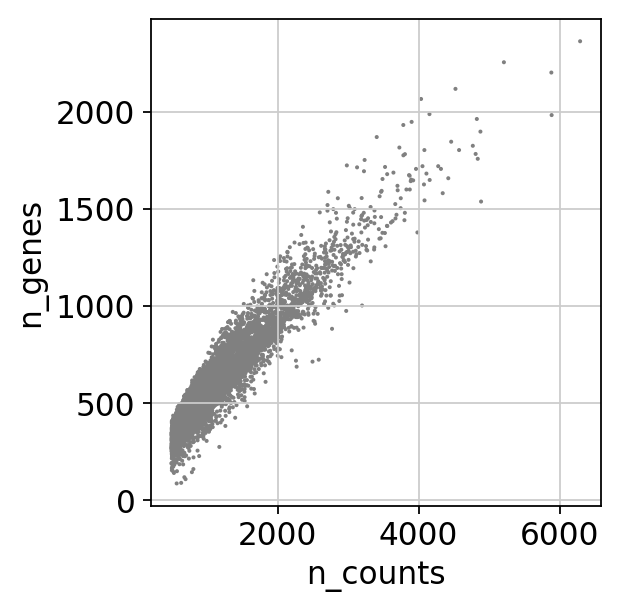

In [48]:
## filter the cells
sc.pl.violin(adata, ['n_genes', 'n_counts','percent_mito'],jitter=0.4, multi_panel=True)
sc.pl.scatter(adata, x='n_counts', y='percent_mito')
sc.pl.scatter(adata, x='n_counts', y='n_genes')

In [49]:
adata = adata[adata.obs['n_genes'] < 2000, :]
adata = adata[adata.obs['percent_mito'] < 0.3, :]

In [50]:
adata

View of AnnData object with n_obs × n_vars = 9111 × 16755 
    obs: 'CellID', 'Batch', 'Cell.Anno', 'CellType', 'n_genes', 'percent_mito', 'n_counts'
    var: 'n_cells'

In [51]:
## normalize
sc.pp.normalize_per_cell(adata)
adata.raw = sc.pp.log1p(adata, copy=True)

In [52]:
filter_result = sc.pp.filter_genes_dispersion(adata.X, min_mean=0.01, max_mean=15, min_disp=0.25)#1934genes

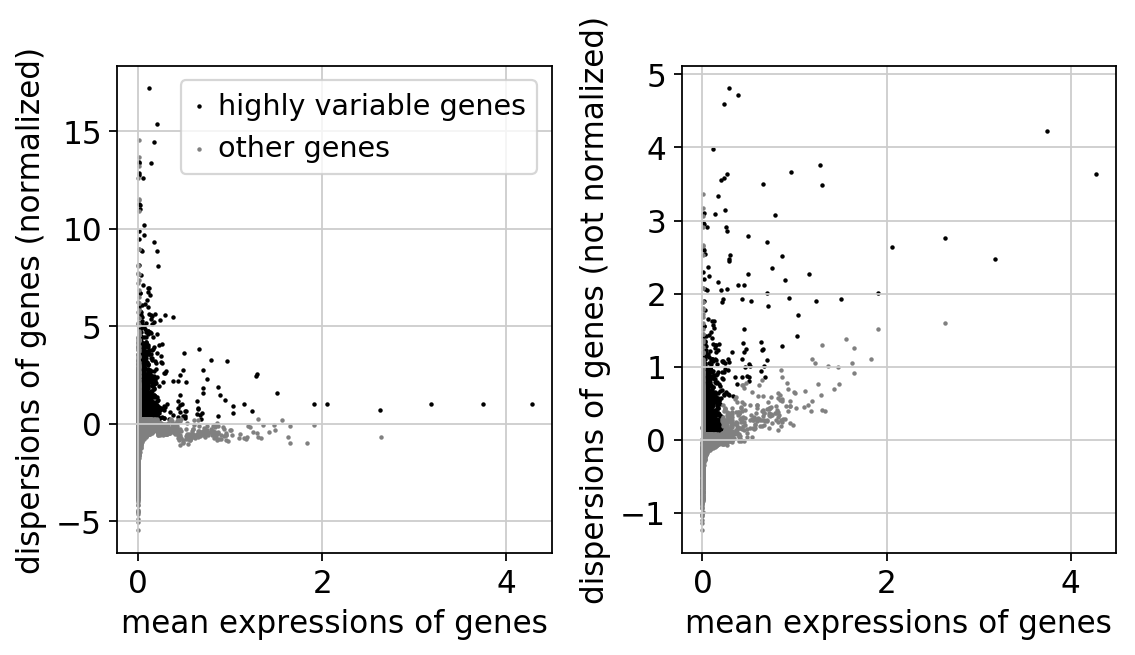

(9111, 1934)

In [53]:
sc.pl.filter_genes_dispersion(filter_result)
adata[:, filter_result.gene_subset].shape

In [54]:
hvgs = adata.var_names[filter_result.gene_subset]

In [55]:
## Actually do the filtering.
#adata1=adata
adata = adata[:, filter_result.gene_subset]

In [56]:
adata_base = adata.copy()

In [3]:
adata_base = sc.read_h5ad("adata_base.h5ad")

In [57]:
## scale the data
sc.pp.scale(adata_base, max_value=10)

In [58]:
## PCA
sc.tl.pca(adata_base)
# Pick nPC
#sc.pl.pca_variance_ratio(adata, log=True, show=100, n_pcs=100)

In [59]:
#nPC=45
sc.pp.neighbors(adata_base, n_neighbors=10,n_pcs=45)

In [60]:
#run tSNE
sc.tl.tsne(adata_base,n_pcs=45,use_fast_tsne=True,n_jobs=20,perplexity=100)

saving figure to file ./figures/tsne_Batch_Baseline.svg


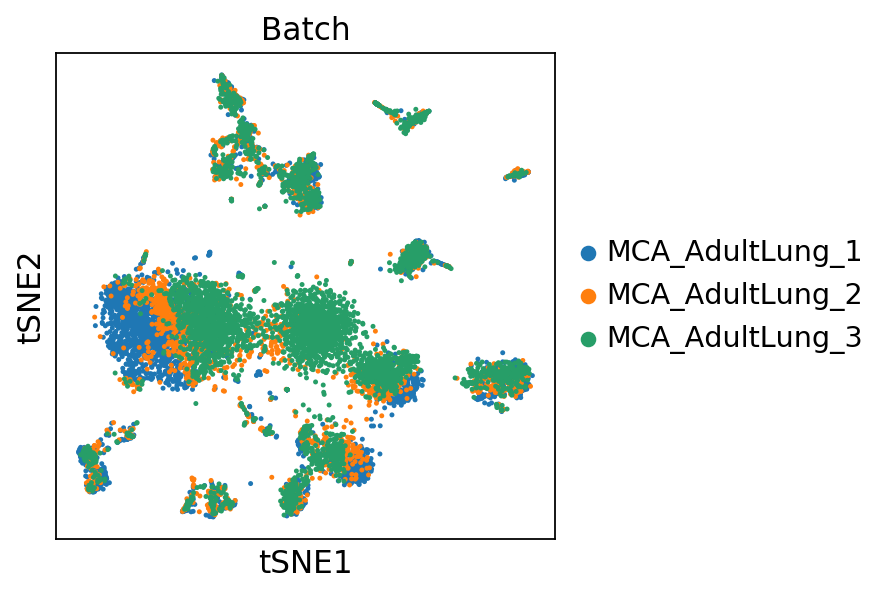

In [4]:
sc.pl.tsne(adata_base, color=['Batch'], size=20, save="_Batch_Baseline.svg")

saving figure to file ./figures/tsne_CellType_Baseline.svg


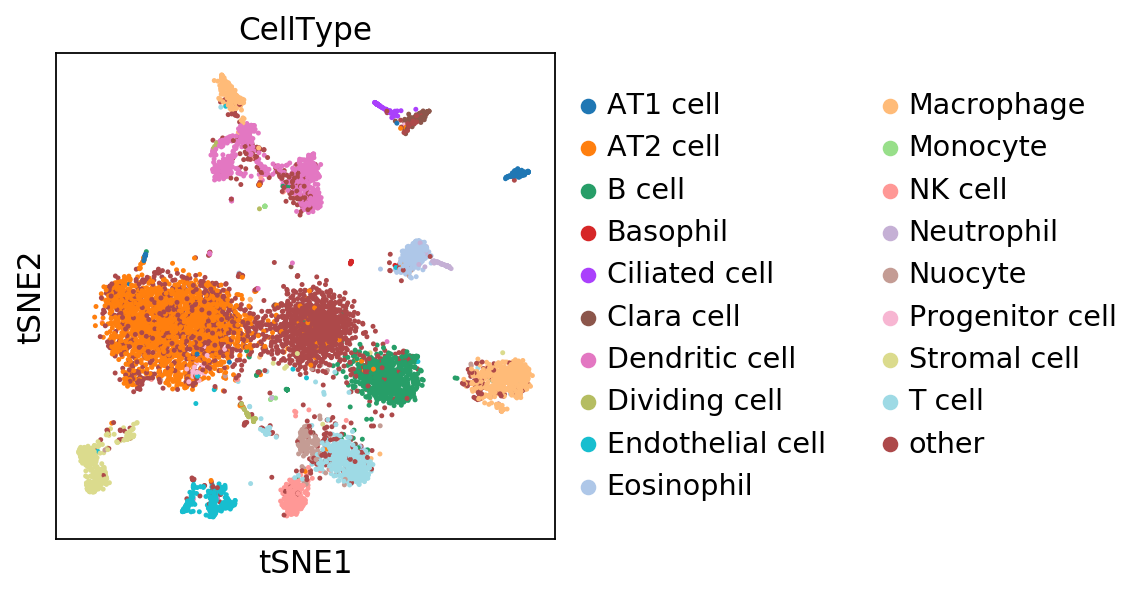

In [5]:
sc.pl.tsne(adata_base, color=['CellType'], size=20, save="_CellType_Baseline.svg")

saving figure to file ./figures/tsne_CellType_Baseline_ondata.svg


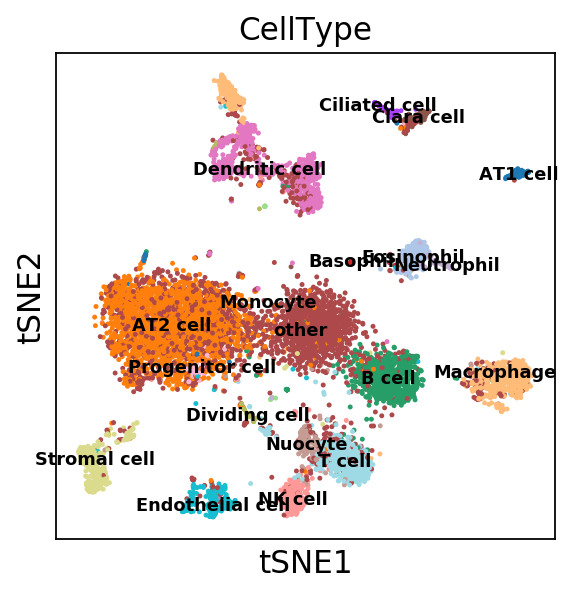

In [6]:
sc.pl.tsne(adata_base, color=['CellType'], size=20, legend_loc='on data', legend_fontsize=8, save="_CellType_Baseline_ondata.svg")

saving figure to file ./figures/tsne_Cluster_baseline.svg


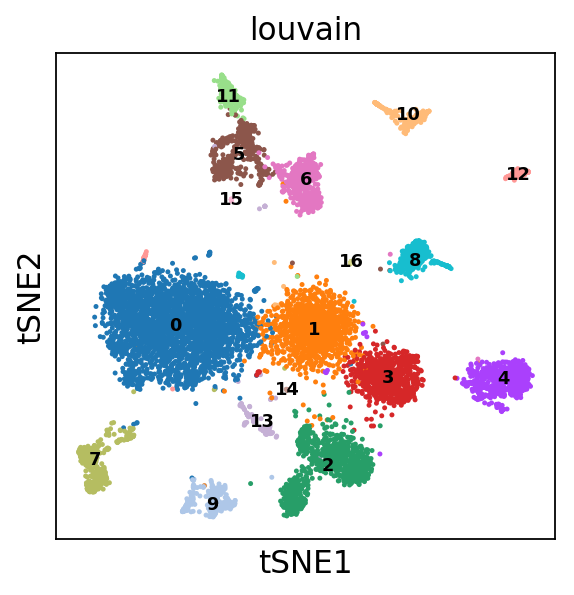

In [7]:
#res=0.6
sc.tl.louvain(adata_base, resolution=0.6)
sc.pl.tsne(adata_base, color='louvain',size=20,legend_loc='on data', legend_fontsize=8,save='_Cluster_baseline.svg')

In [73]:
adata_base.obs['louvain'].to_csv("./cluster_Baseline.txt", index=False)

In [76]:
adata_reg = adata.copy()

In [8]:
adata_reg = sc.read_h5ad("adata_reg.h5ad")

In [77]:
## Regress out effects of total counts per cell and the percentage of mitochondrial genes expressed. Scale the data to unit variance.
logging.info("start scanpy regout\n\n")
start = time.clock()
sc.pp.regress_out(adata_reg, ['n_counts'])
end = time.clock()
logging.info("time scale: second")
logging.info("scanpy regout total running time:\t%f", end - start)
logging.info("\n\nscanpy regout")

/home/ggj/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  This is separate from the ipykernel package so we can avoid doing imports until
/home/ggj/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  """


In [78]:
## scale the data
sc.pp.scale(adata_reg, max_value=10)

In [79]:
## PCA
sc.tl.pca(adata_reg)
# Pick nPC
#sc.pl.pca_variance_ratio(adata, log=True, show=100, n_pcs=100)

In [80]:
#nPC=45
sc.pp.neighbors(adata_reg, n_neighbors=10,n_pcs=45)

In [81]:
#run tSNE
sc.tl.tsne(adata_reg,n_pcs=45,use_fast_tsne=True,n_jobs=20,perplexity=100)

saving figure to file ./figures/tsne_Batch_reg.svg


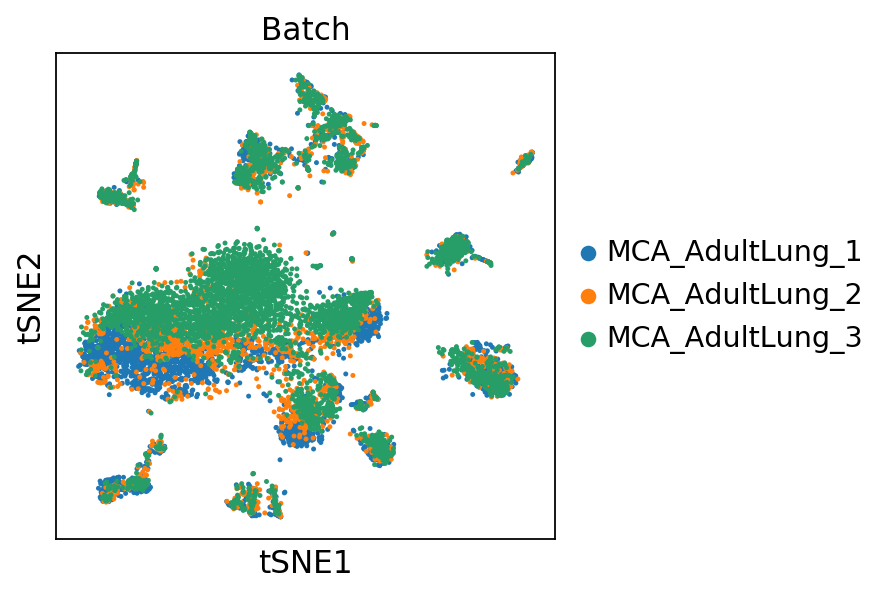

In [9]:
sc.pl.tsne(adata_reg, color=['Batch'], size=20, save="_Batch_reg.svg")

saving figure to file ./figures/tsne_CellType_reg.svg


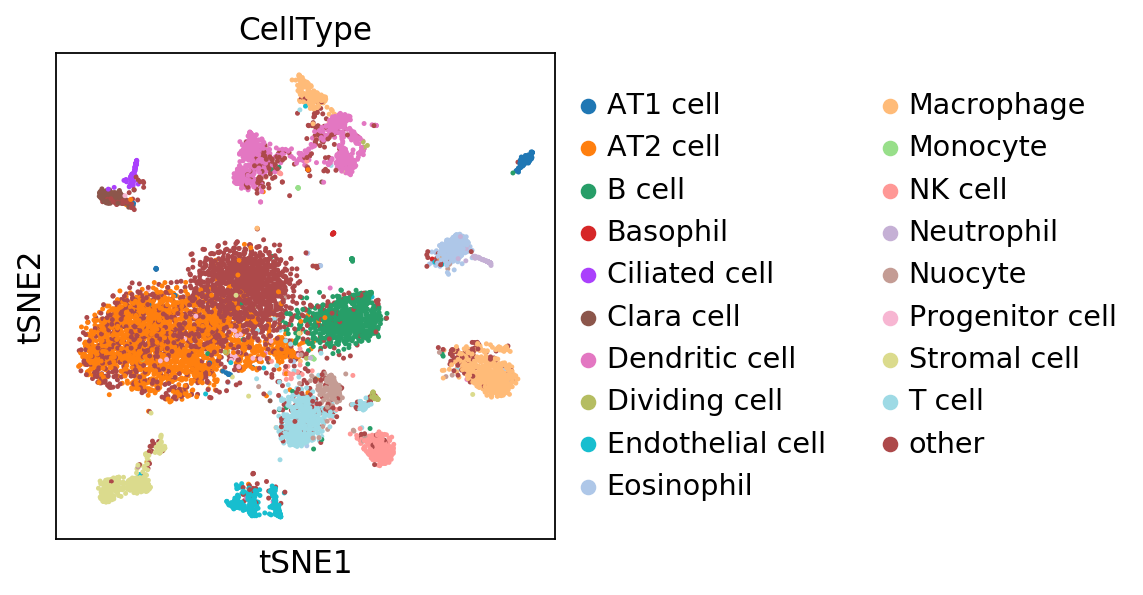

In [10]:
sc.pl.tsne(adata_reg, color=['CellType'], size=20, save="_CellType_reg.svg")

saving figure to file ./figures/tsne_CellType_reg_ondata.svg


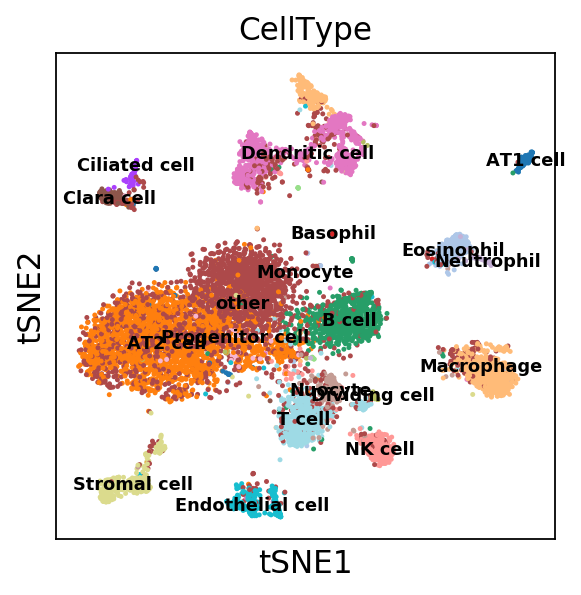

In [11]:
sc.pl.tsne(adata_reg, color=['CellType'], size=20, legend_loc='on data', legend_fontsize=8, save="_CellType_reg_ondata.svg")

saving figure to file ./figures/tsne_Cluster_reg.svg


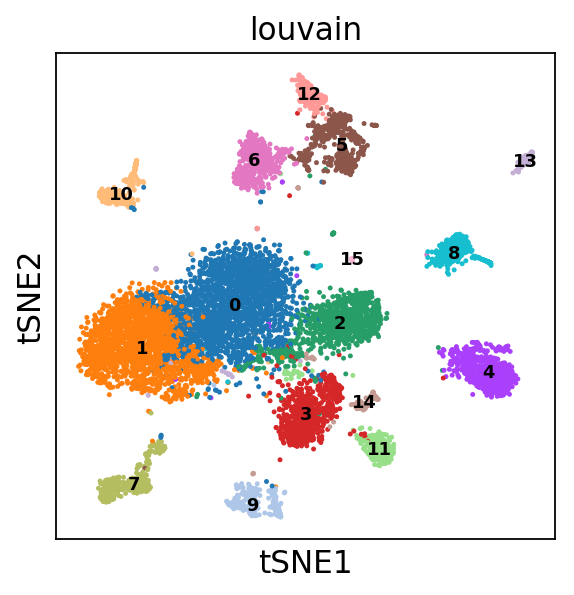

In [12]:
#res=0.6
sc.tl.louvain(adata_reg, resolution=0.6)
sc.pl.tsne(adata_reg, color='louvain',size=20,legend_loc='on data', legend_fontsize=8, save='_Cluster_reg.svg')

In [86]:
adata_reg.obs['louvain'].to_csv("./cluster_reg.txt", index=False)

In [87]:
adata_combat = adata.copy()

In [13]:
adata_combat = sc.read_h5ad("adata_combat.h5ad")

In [88]:
logging.info("start scanpy combat\n\n")
start = time.clock()
sc.pp.combat(adata_combat, key='Batch')
end = time.clock()
logging.info("time scale: second")
logging.info("scanpy combat running time:\t%f", end - start)
logging.info("\n\nEnd scanpy combat")

/home/ggj/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  
Standardizing Data across genes.
found 3 batches
found 0 categorical variables:	
Fitting L/S model and finding priors
Finding parametric adjustments


Adjusting data


/home/ggj/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  after removing the cwd from sys.path.


In [89]:
## scale the data
sc.pp.scale(adata_combat, max_value=10)

In [90]:
## PCA
sc.tl.pca(adata_combat)
# Pick nPC
#sc.pl.pca_variance_ratio(adata, log=True, show=100, n_pcs=100)

In [91]:
#nPC=45
sc.pp.neighbors(adata_combat, n_neighbors=10,n_pcs=45)

In [92]:
#run tSNE
sc.tl.tsne(adata_combat,n_pcs=45,use_fast_tsne=True,n_jobs=20,perplexity=100)

saving figure to file ./figures/tsne_Batch_Combat.svg


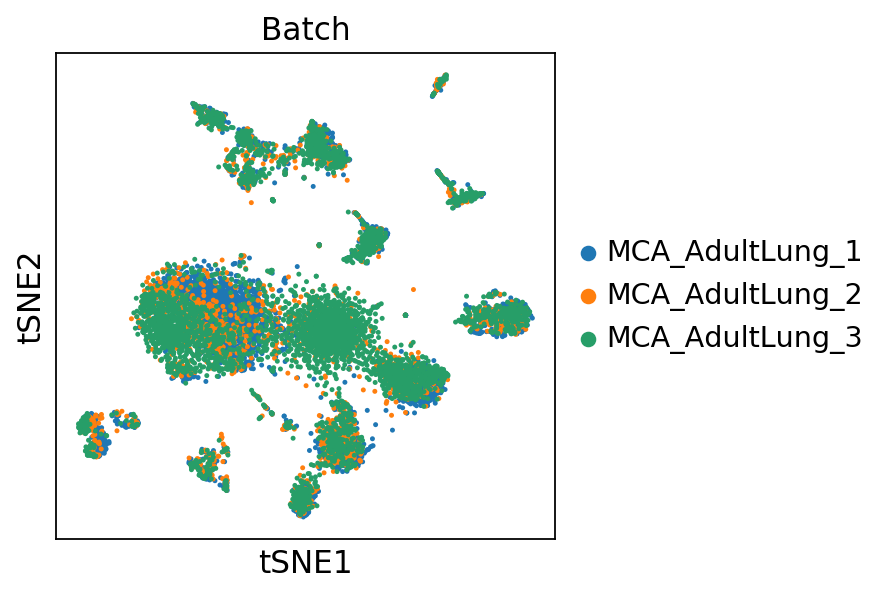

In [14]:
sc.pl.tsne(adata_combat, color=['Batch'], size=20, save="_Batch_Combat.svg")

saving figure to file ./figures/tsne_CellType_Combat.svg


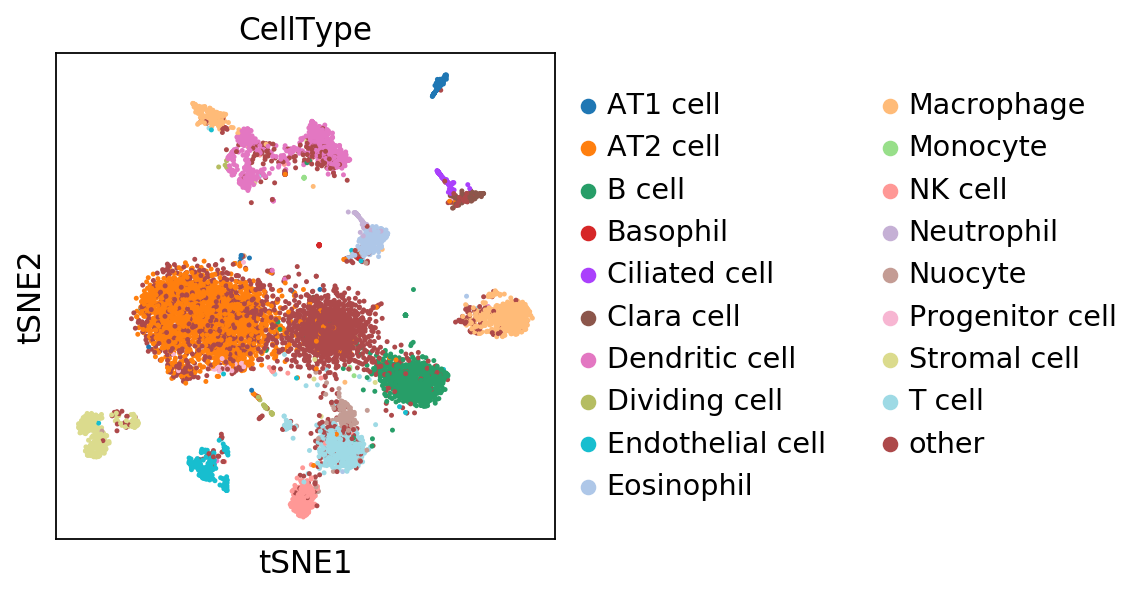

In [15]:
sc.pl.tsne(adata_combat, color=['CellType'], size=20, save="_CellType_Combat.svg")

saving figure to file ./figures/tsne_CellType_Combat_ondata.svg


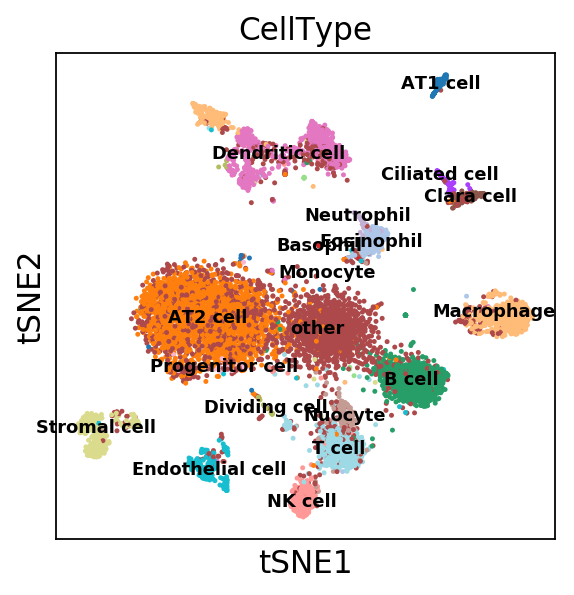

In [16]:
sc.pl.tsne(adata_combat, color=['CellType'], size=20, legend_loc='on data', legend_fontsize=8, save="_CellType_Combat_ondata.svg")

saving figure to file ./figures/tsne_Cluster_Combat.svg


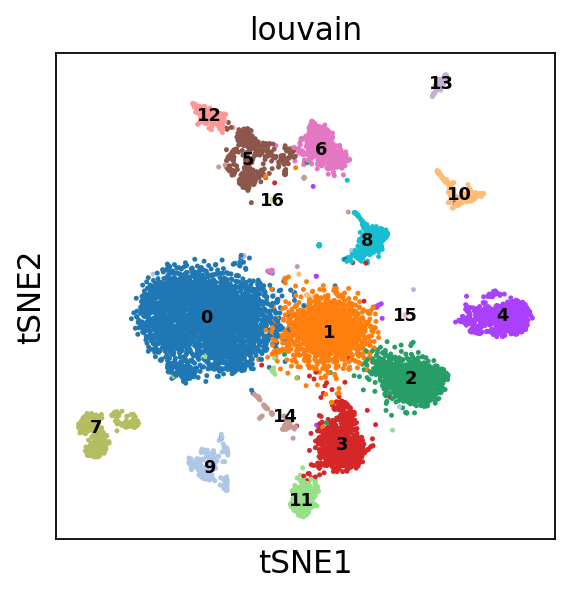

In [17]:
#res=0.6
sc.tl.louvain(adata_combat, resolution=0.6)
sc.pl.tsne(adata_combat, color='louvain', size=20, legend_loc='on data', legend_fontsize=8,save='_Cluster_Combat.svg')

In [97]:
adata_combat.obs['louvain'].to_csv("./cluster_Combat.txt", index=False)

In [98]:
adata_scanorama = adata.copy()

In [18]:
corrected_merged_dge = sc.read_h5ad("./adata_scanorama.h5ad")

In [99]:
adata_list = [adata_scanorama[adata_scanorama.obs['Batch'] == i] for i in adata_scanorama.obs['Batch'].unique()]

In [100]:
#check
print(adata_list[0].shape)
print(adata_list[0])

(2833, 1934)
View of AnnData object with n_obs × n_vars = 2833 × 1934 
    obs: 'CellID', 'Batch', 'Cell.Anno', 'CellType', 'n_genes', 'percent_mito', 'n_counts'
    var: 'n_cells'


In [101]:
import scanorama

In [102]:
logging.info("start scanorama\n\n")
start = time.clock()
intergrated, corrected = scanorama.correct_scanpy(adata_list, return_dimred=True)
correct_end = time.clock()
corrected_merged_dge = corrected[0].concatenate(corrected[1:], join='outer')
merged_end = time.clock()
logging.info("time scale: second")
logging.info("scanoram correct batch time:\t%f", correct_end - start)
logging.info("scanoram merging time:\t%f", merged_end - correct_end)
logging.info("scanoram total running time:\t%f", merged_end - start)
logging.info("\n\nend scanorama")

/home/ggj/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  


Found 1934 genes among all datasets
[[0.         0.57536181 0.5326509 ]
 [0.         0.         0.82375906]
 [0.         0.         0.        ]]
Processing datasets (1, 2)
Processing datasets (0, 1)
Processing datasets (0, 2)


/home/ggj/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  after removing the cwd from sys.path.
/home/ggj/anaconda3/lib/python3.7/site-packages/scipy/sparse/lil.py:512: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writable flag explicitly to avoid this warning.
  if not i.flags.writeable or i.dtype not in (np.int32, np.int64):
/home/ggj/anaconda3/lib/python3.7/site-packages/scipy/sparse/lil.py:514: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writable flag explicitly to avoid this warning.
  if not j.flags.writeable or j.dtype not in (np.int32, np.int64):
/home/ggj/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Pytho

In [103]:
corrected_merged_dge.obs = adata_scanorama.obs

In [104]:
## scale the data
sc.pp.scale(corrected_merged_dge, max_value=10)

In [105]:
## PCA
sc.tl.pca(corrected_merged_dge)
# Pick nPC
#sc.pl.pca_variance_ratio(adata, log=True, show=100, n_pcs=100)

In [106]:
#nPC=45
sc.pp.neighbors(corrected_merged_dge, n_neighbors=10,n_pcs=45)

In [107]:
#run tSNE
sc.tl.tsne(corrected_merged_dge,n_pcs=45,use_fast_tsne=True,n_jobs=20,perplexity=100)

saving figure to file ./figures/tsne_Batch_Scanorama.svg


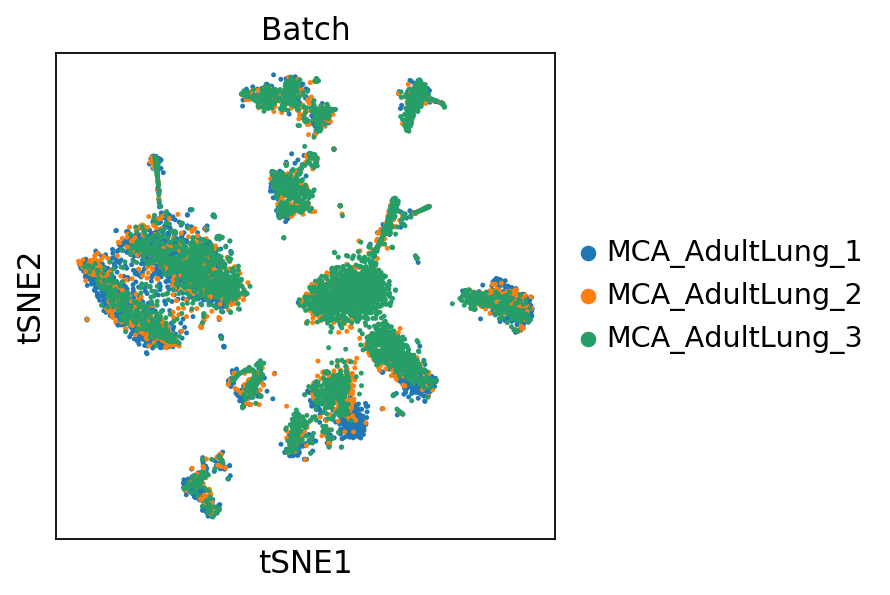

In [19]:
sc.pl.tsne(corrected_merged_dge, color=['Batch'], size=20, save="_Batch_Scanorama.svg")

saving figure to file ./figures/tsne_CellType_Scanorama.svg


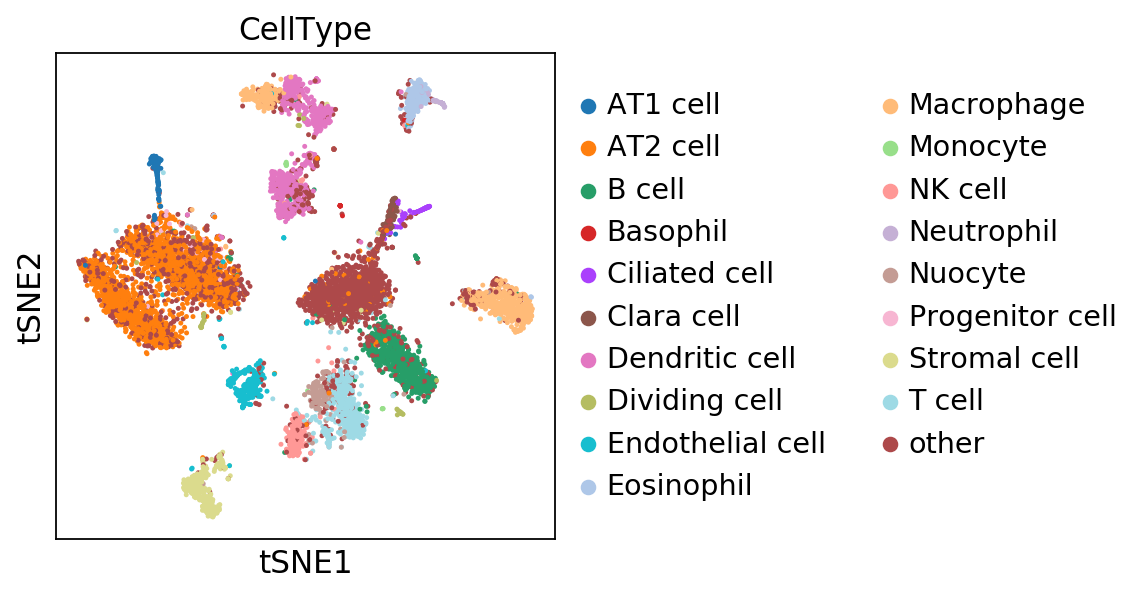

In [20]:
sc.pl.tsne(corrected_merged_dge, color=['CellType'], size=20, save="_CellType_Scanorama.svg")

saving figure to file ./figures/tsne_CellType_Scanoram_ondata.svg


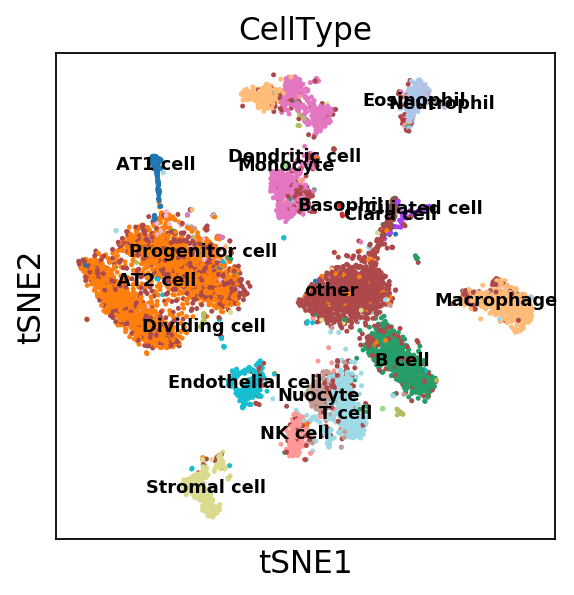

In [21]:
sc.pl.tsne(corrected_merged_dge, color=['CellType'], size=20, legend_loc='on data', legend_fontsize=8, save="_CellType_Scanoram_ondata.svg")

saving figure to file ./figures/tsne_Cluster_Scanorama.svg


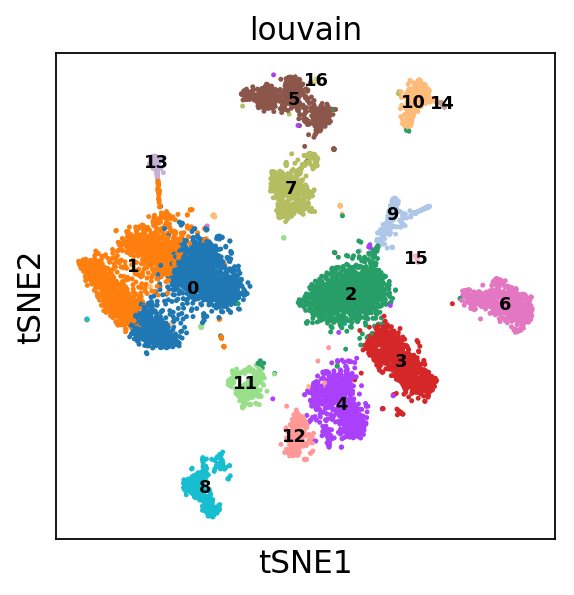

In [22]:
#res=0.6
sc.tl.louvain(corrected_merged_dge, resolution=0.6)
sc.pl.tsne(corrected_merged_dge, color='louvain', size=20, legend_loc='on data', legend_fontsize=8,save='_Cluster_Scanorama.svg')

In [111]:
corrected_merged_dge.obs['louvain'].to_csv("./cluster_Scanorama.txt", index=False)

In [112]:
import mnnpy

In [23]:
mnn_adata = sc.read_h5ad("adata_mnns.h5ad")

In [113]:
logging.info("start MNNPY\n\n")
start = time.clock()
corrected = mnnpy.mnn_correct(*adata_list, var_subset=hvgs)
correct_end = time.clock()
mnn_adata = corrected[0]
merged_end = time.clock()
logging.info("time scale: second")
logging.info("MNNPY correct batch time:\t%f", correct_end - start)
logging.info("MNNPY merging time:\t%f", merged_end - correct_end)
logging.info("MNNPY total running time:\t%f", merged_end - start)
logging.info("\n\nend MNNPY")

Performing cosine normalization...


/home/ggj/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  


Starting MNN correct iteration. Reference batch: 0
Step 1 of 2: processing batch 1
  Looking for MNNs...
  Computing correction vectors...
  Adjusting variance...
  Applying correction...
Step 2 of 2: processing batch 2
  Looking for MNNs...
  Computing correction vectors...
  Adjusting variance...
  Applying correction...
MNN correction complete. Gathering output...
Packing AnnData object...
Done.


/home/ggj/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  after removing the cwd from sys.path.
/home/ggj/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  


In [114]:
## scale the data
sc.pp.scale(mnn_adata, max_value=10)

In [115]:
## PCA
sc.tl.pca(mnn_adata)
# Pick nPC
#sc.pl.pca_variance_ratio(adata, log=True, show=100, n_pcs=100)

In [116]:
#nPC=45
sc.pp.neighbors(mnn_adata, n_neighbors=10,n_pcs=45)

In [117]:
#run tSNE
sc.tl.tsne(mnn_adata,n_pcs=45,use_fast_tsne=True,n_jobs=20,perplexity=100)

saving figure to file ./figures/tsne_Batch_MNNs.svg


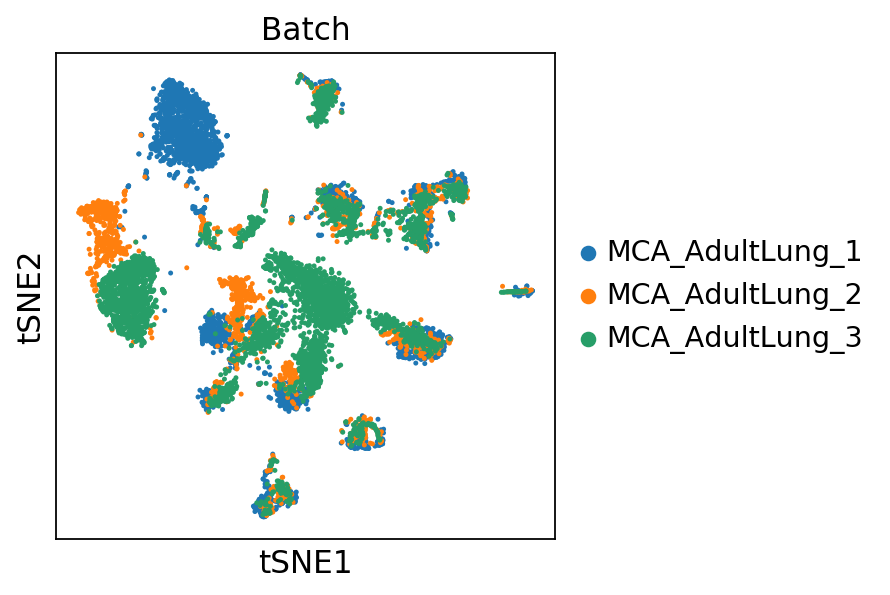

In [24]:
sc.pl.tsne(mnn_adata, color=['Batch'], size=20, save="_Batch_MNNs.svg")

saving figure to file ./figures/tsne_CellType_MNNs.svg


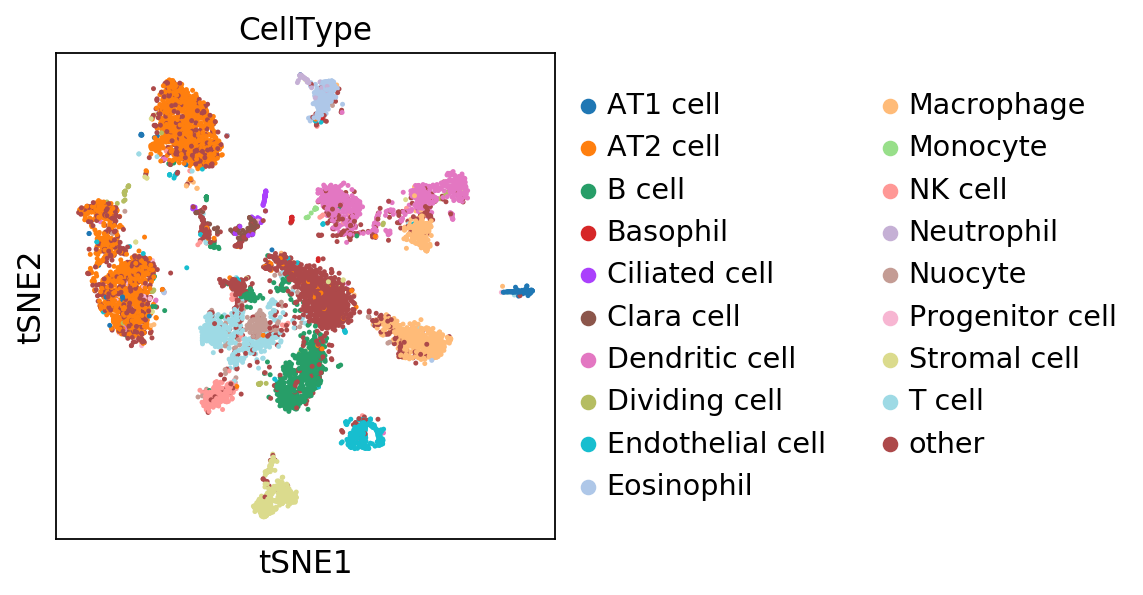

In [25]:
sc.pl.tsne(mnn_adata, color=['CellType'], size=20, save="_CellType_MNNs.svg")

saving figure to file ./figures/tsne_CellType_MNNs_ondata.svg


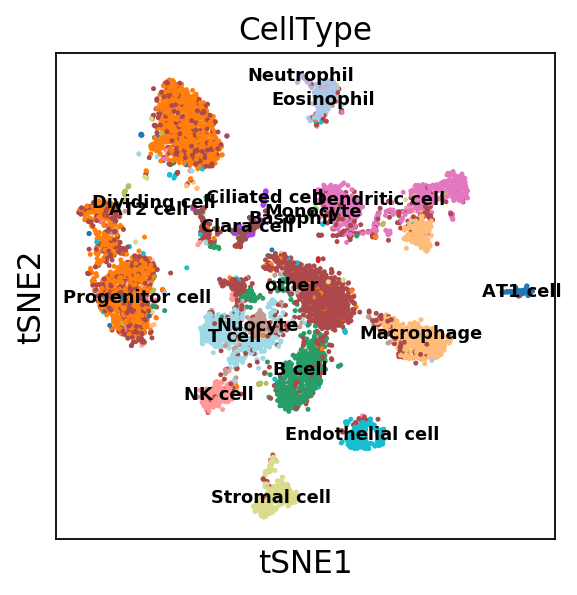

In [26]:
sc.pl.tsne(mnn_adata, color=['CellType'], size=20, legend_loc='on data', legend_fontsize=8, save="_CellType_MNNs_ondata.svg")

saving figure to file ./figures/tsne_Cluster_MNNs.svg


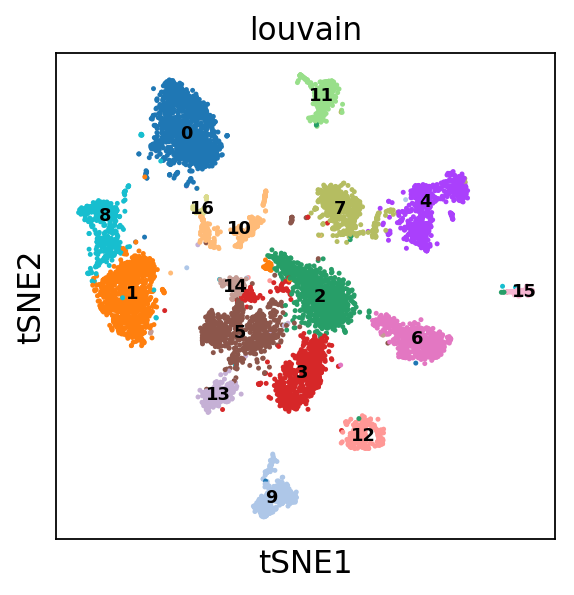

In [27]:
#res=0.6
sc.tl.louvain(mnn_adata, resolution=0.6)
sc.pl.tsne(mnn_adata, color='louvain', size=20, legend_loc='on data', legend_fontsize=8, save='_Cluster_MNNs.svg')

In [142]:
mnn_adata.obs['louvain'].to_csv("./cluster_MNNs.txt", index=False)

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.stats import ttest_ind
from sklearn.metrics import silhouette_samples as sil

In [29]:
def calculate_silh(X, label_fname):
    labels = np.array( open(label_fname).read().rstrip().split() )
    idx = range(labels.shape[0])
    sil_val = sil(X[idx, :], labels[idx])
    print(np.median(sil_val))
    return sil_val

In [140]:
X = dge.X

In [30]:
X = sc.read_h5ad("dge.h5ad").X

In [31]:
# Baseline Scanpy.
print("silh score of scanpy baseline")
sil_non = calculate_silh(X, './cluster_Baseline.txt')
# regout Scanpy
print("silh score of scanpy Regout:")
sil_regout = calculate_silh(X, 'cluster_reg.txt')
# regout Scanpy
print("silh score of scanpy Combat:")
sil_scanpy = calculate_silh(X, './cluster_Combat.txt')
# scanorama scanpy
print("silh score of Scanoram:")
sil_scano = calculate_silh(X,"./cluster_Scanorama.txt")
# MNNs
print("silh score of MNNs:")
sil_MNN = calculate_silh(X,"./cluster_MNNs.txt")

silh score of scanpy baseline
-0.12408371
silh score of scanpy Regout:
-0.14097421
silh score of scanpy Combat:
-0.11713036
silh score of Scanoram:
-0.13938469
silh score of MNNs:
-0.12649031


In [32]:
print("\n\n-----Ttest------\n\n")
# t-test
print("ttest of regout to baseline:")
print(ttest_ind(sil_regout, sil_non))
print("ttest of combat to baseline:")
print(ttest_ind(sil_scanpy, sil_non))
print("ttest of scanoram to baseline:")
print(ttest_ind(sil_scano, sil_non))
print("ttest of MNNs to baseline:")
print(ttest_ind(sil_MNN, sil_non))
print("ttest of Combat to Regout:")
print(ttest_ind(sil_scanpy, sil_regout))
print("ttest of Scanoram to Regout:")
print(ttest_ind(sil_scano, sil_regout))
print("ttest of MNNs to Regout:")
print(ttest_ind(sil_MNN, sil_regout))
print("ttest of Scanoram to Combat:")
print(ttest_ind(sil_scano, sil_scanpy))
print("ttest of MNNs to Combat:")
print(ttest_ind(sil_MNN, sil_scanpy))
print("ttest of MNNs to Scanoram:")
print(ttest_ind(sil_MNN, sil_scano))



-----Ttest------


ttest of regout to baseline:
Ttest_indResult(statistic=-11.482776625124929, pvalue=2.0490697978788187e-30)
ttest of combat to baseline:
Ttest_indResult(statistic=-0.5968369822853502, pvalue=0.5506236400202495)
ttest of scanoram to baseline:
Ttest_indResult(statistic=-0.3651472364031075, pvalue=0.7150057404721439)
ttest of MNNs to baseline:
Ttest_indResult(statistic=-8.39436637663087, pvalue=5.023135484264276e-17)
ttest of Combat to Regout:
Ttest_indResult(statistic=11.261847497594982, pvalue=2.530879709213567e-29)
ttest of Scanoram to Regout:
Ttest_indResult(statistic=10.99595125939395, pvalue=4.8963664317571355e-28)
ttest of MNNs to Regout:
Ttest_indResult(statistic=2.098615430346832, pvalue=0.0358645445538187)
ttest of Scanoram to Combat:
Ttest_indResult(statistic=0.21936859229985917, pvalue=0.8263653912312754)
ttest of MNNs to Combat:
Ttest_indResult(statistic=-8.039890675494242, pvalue=9.537916075305015e-16)
ttest of MNNs to Scanoram:
Ttest_indResult(statistic=

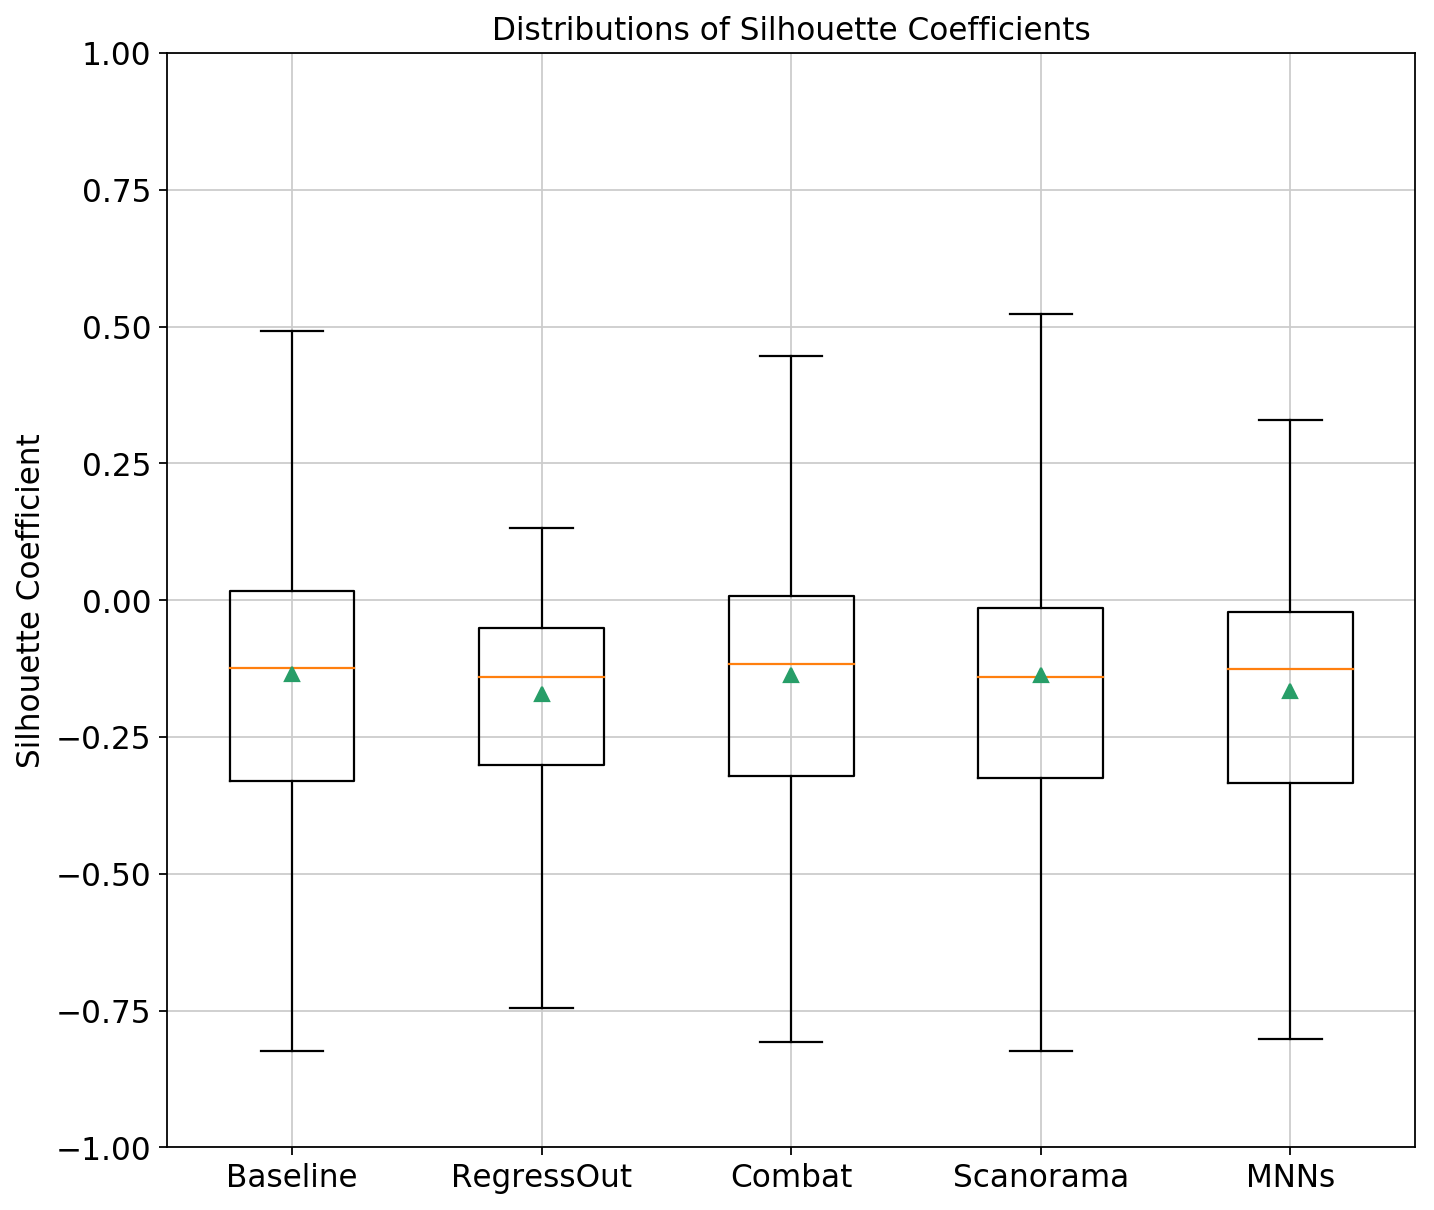

In [145]:
# visualization
plt.figure()
plt.boxplot([ sil_non, sil_regout, sil_scanpy, sil_scano, sil_MNN ], showmeans=True, whis='range')
plt.ylim([ -1, 1 ])
plt.title('Distributions of Silhouette Coefficients')
plt.xticks(range(1, 6), [ 'Baseline','RegressOut', 'Combat', 'Scanorama', "MNNs" ])
plt.ylabel('Silhouette Coefficient')
plt.savefig('silhouette_dge.svg')

In [101]:
X = adata.X

In [146]:
# Baseline Scanpy.
print("silh score of scanpy baseline")
sil_non = calculate_silh(X, './cluster_Baseline.txt')
# regout Scanpy
print("silh score of scanpy Regout:")
sil_regout = calculate_silh(X, 'cluster_reg.txt')
# regout Scanpy
print("silh score of scanpy Combat:")
sil_scanpy = calculate_silh(X, './cluster_Combat.txt')
# scanorama scanpy
print("silh score of Scanoram:")
sil_scano = calculate_silh(X,"./cluster_Scanorama.txt")
# MNNs
print("silh score of MNNs:")
sil_MNN = calculate_silh(X,"./cluster_MNNs.txt")

silh score of scanpy baseline
-0.12408371
silh score of scanpy Regout:
-0.14097421
silh score of scanpy Combat:
-0.11713036
silh score of Scanoram:
-0.13938469
silh score of MNNs:
-0.12649031


In [147]:
print("\n\n-----Ttest------\n\n")
# t-test
print("ttest of regout to baseline:")
print(ttest_ind(sil_regout, sil_non))
print("ttest of regout to baseline:")
print(ttest_ind(sil_scanpy, sil_non))
print("ttest of scanoram to baseline:")
print(ttest_ind(sil_scano, sil_non))
print("ttest of MNNs to baseline:")
print(ttest_ind(sil_MNN, sil_non))



-----Ttest------


ttest of regout to baseline:
Ttest_indResult(statistic=-11.482776625124929, pvalue=2.0490697978788187e-30)
ttest of regout to baseline:
Ttest_indResult(statistic=-0.5968369822853502, pvalue=0.5506236400202495)
ttest of scanoram to baseline:
Ttest_indResult(statistic=-0.3651472364031075, pvalue=0.7150057404721439)
ttest of MNNs to baseline:
Ttest_indResult(statistic=-8.39436637663087, pvalue=5.023135484264276e-17)


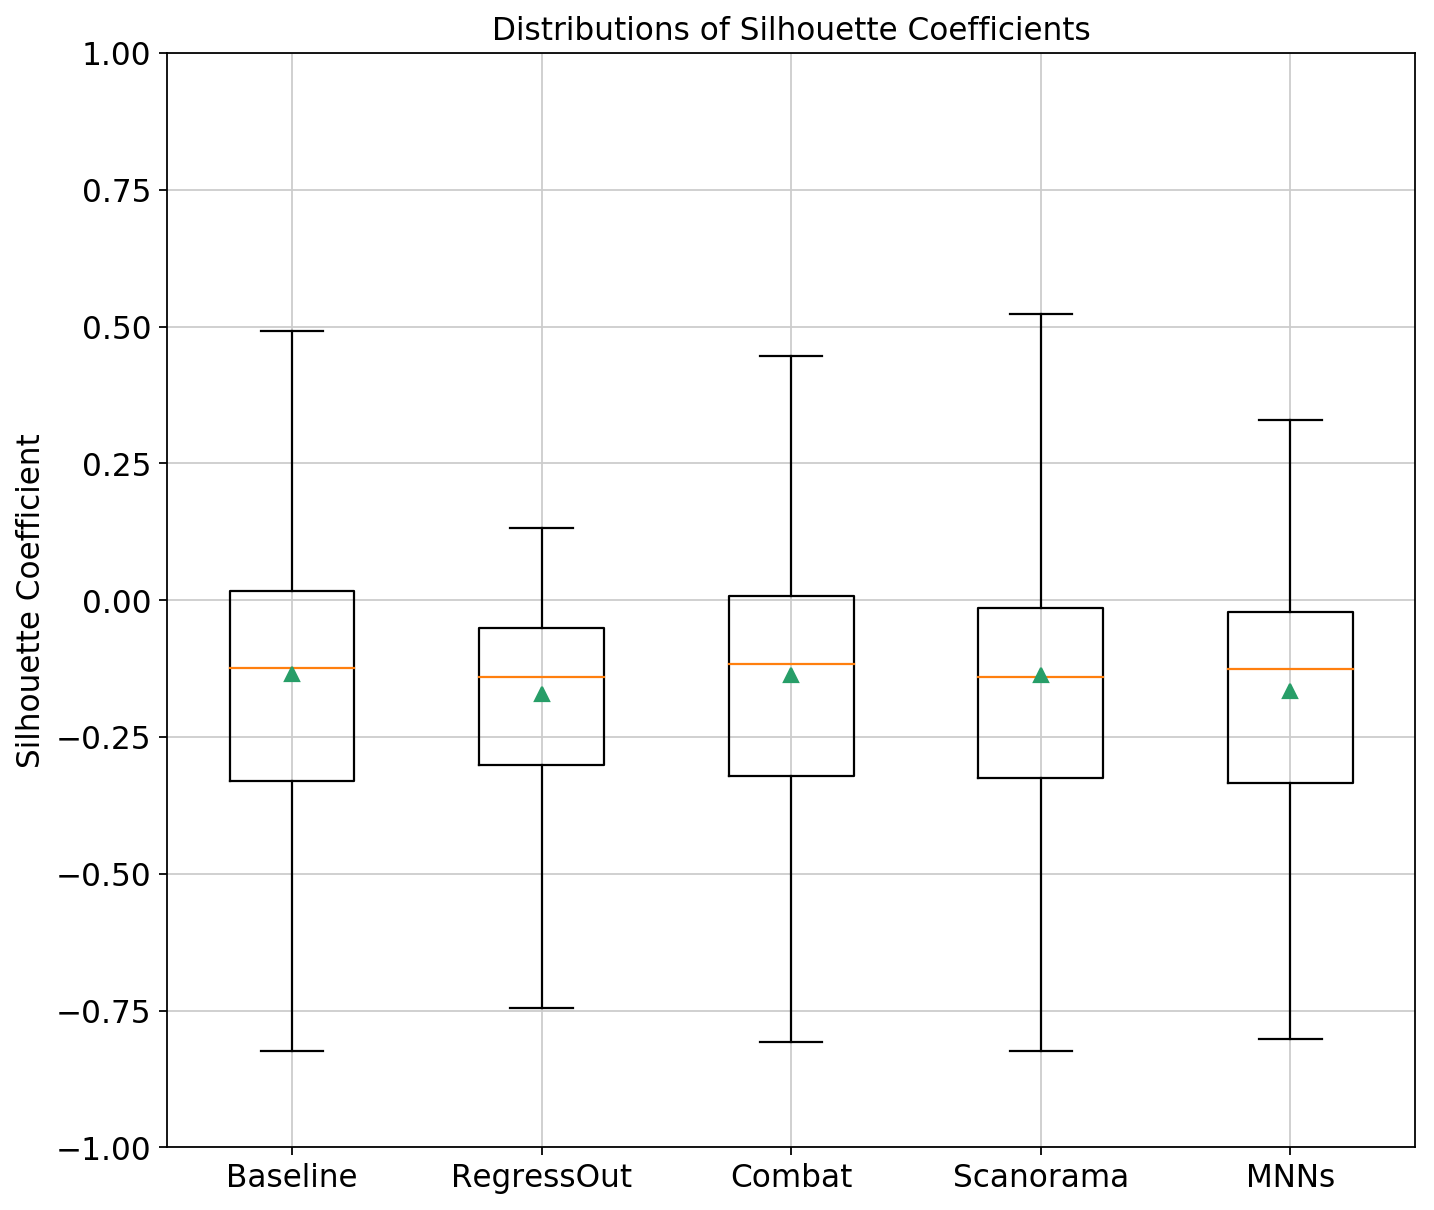

In [148]:
# visualization
plt.figure()
plt.boxplot([ sil_non, sil_regout, sil_scanpy, sil_scano, sil_MNN ], showmeans=True, whis='range')
plt.ylim([ -1, 1 ])
plt.title('Distributions of Silhouette Coefficients')
plt.xticks(range(1, 6), [ 'Baseline','RegressOut', 'Combat', 'Scanorama', "MNNs" ])
plt.ylabel('Silhouette Coefficient')
plt.savefig('silhouette_dge.svg')

In [149]:
# Baseline Scanpy.
print("silh score of scanpy baseline")
sil_non = calculate_silh(adata_base.X, './cluster_Baseline.txt')
# Regout Scanpy.
print("silh score of scanpy Regout")
sil_non = calculate_silh(adata_reg.X, './cluster_Baseline.txt')
# regout Scanpy
print("silh score of scanpy Combat:")
sil_scanpy = calculate_silh(adata_combat.X, './cluster_Combat.txt')
# scanorama scanpy
print("silh score of Scanoram:")
sil_scano = calculate_silh(corrected_merged_dge.X,"./cluster_Scanorama.txt")
# MNNs
print("silh score of MNNs:")
sil_MNN = calculate_silh(mnn_adata.X,"./cluster_MNNs.txt")

silh score of scanpy baseline
-0.14173314
silh score of scanpy Regout
-0.14537492
silh score of scanpy Combat:
-0.14168500599399936
silh score of Scanoram:
-0.14590709
silh score of MNNs:
-0.13484031


In [150]:
print("\n\n-----Ttest------\n\n")
# t-test
print("ttest of regout to baseline:")
print(ttest_ind(sil_regout, sil_non))
print("ttest of regout to baseline:")
print(ttest_ind(sil_scanpy, sil_non))
print("ttest of scanoram to baseline:")
print(ttest_ind(sil_scano, sil_non))
print("ttest of MNNs to baseline:")
print(ttest_ind(sil_MNN, sil_non))



-----Ttest------


ttest of regout to baseline:
Ttest_indResult(statistic=-45.054902780860665, pvalue=0.0)
ttest of regout to baseline:
Ttest_indResult(statistic=0.14230645905359965, pvalue=0.8868395183502259)
ttest of scanoram to baseline:
Ttest_indResult(statistic=-37.22684531460134, pvalue=2.047729238079524e-292)
ttest of MNNs to baseline:
Ttest_indResult(statistic=-30.645874308459835, pvalue=3.716339138768063e-201)


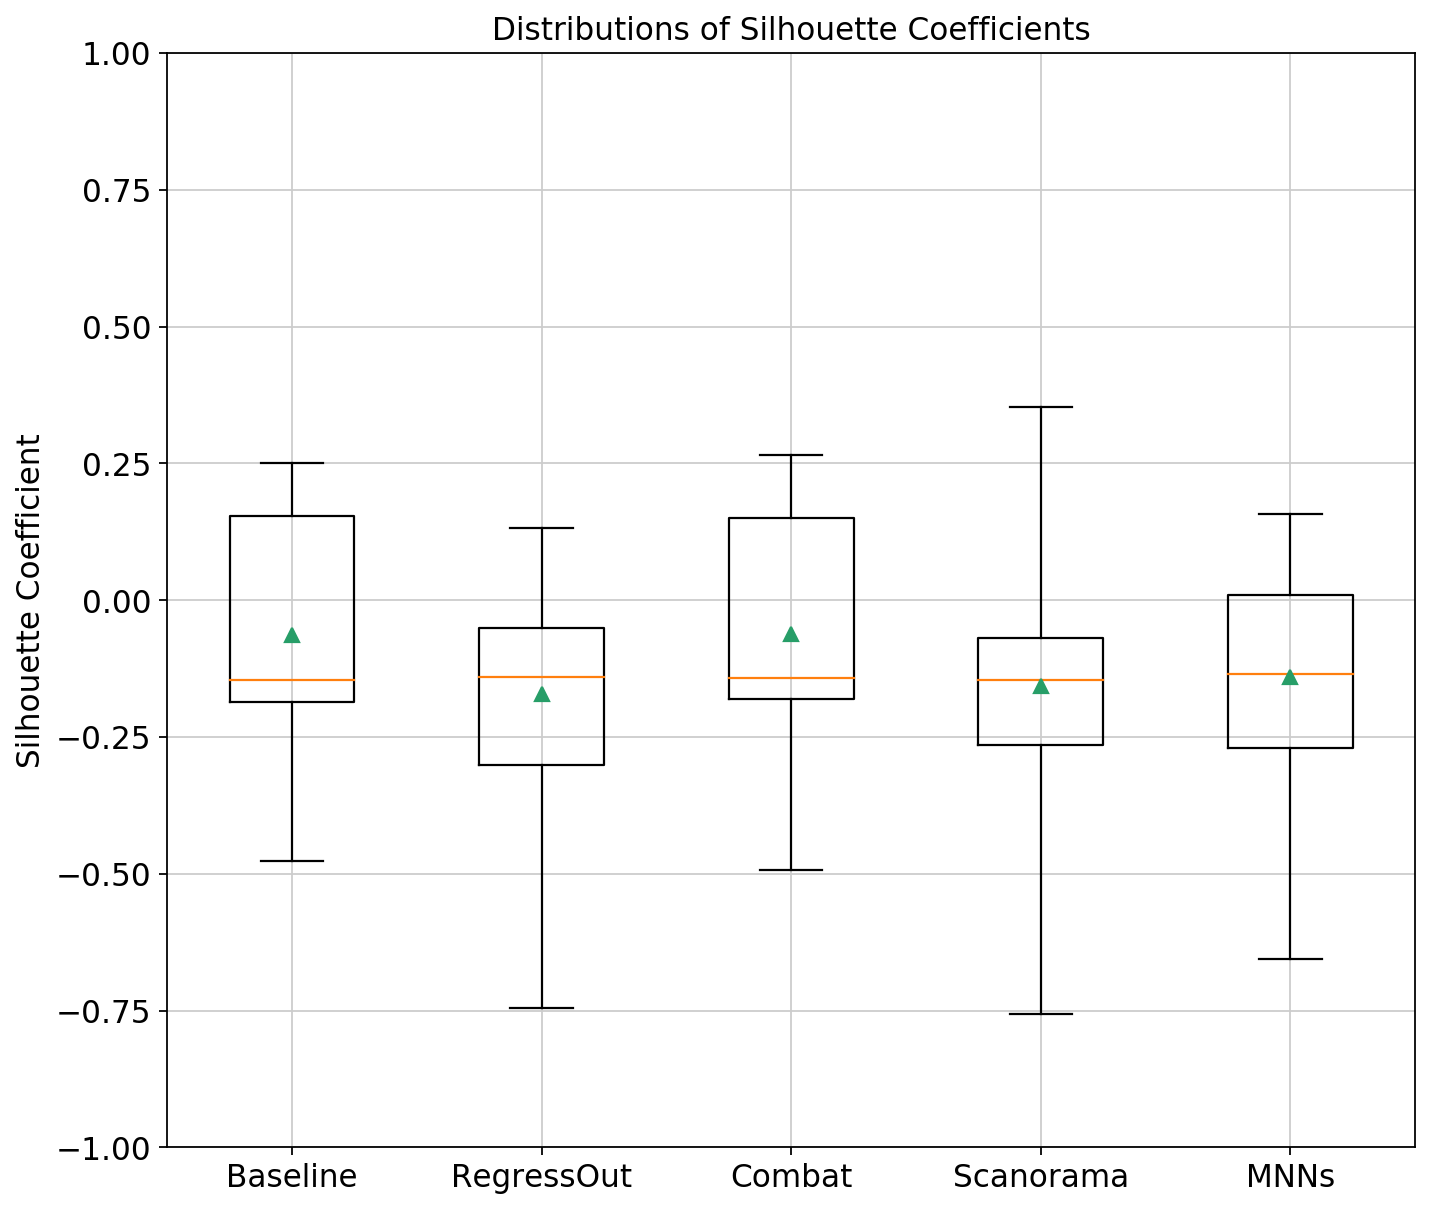

In [151]:
# visualization
plt.figure()
plt.boxplot([ sil_non, sil_regout, sil_scanpy, sil_scano, sil_MNN ], showmeans=True, whis='range')
plt.ylim([ -1, 1 ])
plt.title('Distributions of Silhouette Coefficients')
plt.xticks(range(1, 6), [ 'Baseline','RegressOut', 'Combat', 'Scanorama', "MNNs" ])
plt.ylabel('Silhouette Coefficient')
plt.savefig('silhouette_dge.svg')

In [137]:
dge.write("./dge.h5ad")
adata.write("./adata.h5ad")
adata_base.write("./adata_base.h5ad")
adata_combat.write("./adata_combat.h5ad")
adata_reg.write("./adata_reg.h5ad")
corrected_merged_dge.write("./adata_scanorama.h5ad")
mnn_adata.write("./adata_mnns.h5ad")

... storing 'Batch' as categorical
... storing 'Cell.Anno' as categorical
... storing 'CellType' as categorical
